# 1.4 2-D Building  for snapshot

### This notebook is a modfied version of '2d Buildin initial.ipynb' for output the snapshot of the wavefields.
#### ...........................................................................................................................................................................................
#### Initially edited by Salvus group of ETH (https://salvus.io/)
#### Modified by Yingjie Gao (gaoyingjie@mail.iggcas.ac.cn;gaoyingjie12@mails.ucas.ac.cn) 
#### Institute of Geology and Geophysics, Chinase Academy of Sciences, Beijing, China, 100029
#### ...........................................................................................................................................................................................

In [1]:
# Magic
# %autosave 0
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
# Standard Python packages
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pathlib import Path
from functools import partial

# Salvus packages
import salvus_flow.simple_config as config
import salvus_toolbox.toolbox as st
import salvus_toolbox.toolbox_geotech as st_geo
import salvus_flow.simple_config as sc
from salvus_flow import api

import salvus_mesh.structured_grid_2D as sg2d
import salvus_mesh.structured_grid_3D as sg3d
import salvus_mesh.unstructured_mesh as um

## Generating the mesh

In [3]:
n_stories = 50             # number of building stories
wall_width = 1.0           
story_height = 3.0
ceiling_height = 0.3     
building_width = 20.0
basement_depth = 20.0
basement_width = 100.0

In [4]:
# f_max = 500.0
# vs_min = 1500.0
# nelem_per_wavelength = 2.0

f_max = 10.0
vs_min = 2000.0
nelem_per_wavelength = 15.0

In [5]:
mesh, bnd = st_geo.get_simple_building(
    f_max=f_max,
    vs_min=vs_min,
    n_stories=n_stories,
    wall_width=wall_width,
    story_height=story_height,
    basement_width=basement_width,
    basement_depth=basement_depth,
    building_width=building_width,
    ceiling_height=ceiling_height,
    nelem_per_wavelength=nelem_per_wavelength,
)

In [6]:
nodes = mesh.get_element_nodes()[:, :, 0]
mesh.attach_field("RHO", np.ones_like(nodes) * 1000)
# mesh.attach_field("VS", np.ones_like(nodes) * vs_min)
# mesh.attach_field("VP", np.ones_like(nodes) * vs_min * 2)
mesh.attach_field("VS", np.ones_like(nodes) * 2000.0)      #S wave velocity for concrete: 2000 m/s
mesh.attach_field("VP", np.ones_like(nodes) * 3600.0)      #P wave velocity for concrete: 3600 m/s

#.................................................
# edit by Yingjie   2019-08-25 for heterogenous media
y_centroids = mesh.get_element_centroid()[:, 1]
basement_elems = np.where(y_centroids < 0)
mesh.element_nodal_fields["VS"][basement_elems] = 1000.0    #S wave velocity for clay: 400-1000 m/s
mesh.element_nodal_fields["VP"][basement_elems] = 2000.0    #P wave velocity for concrete: 1000-2500 m/s
#.................................................   

In [7]:
mesh
# help(mesh)

# Write the mesh to a file which can be visualized in Paraview.
# Open the associated lambs_problem_mesh.xdmf to visualize.
# mesh.write_h5_tensorized_model("2D_building_mesh.h5")

## Setting up the simulation

### Salvus built-in Source Time Function (stf)

{'center-frequency': 5.0, 'wavelet': 'ricker'}


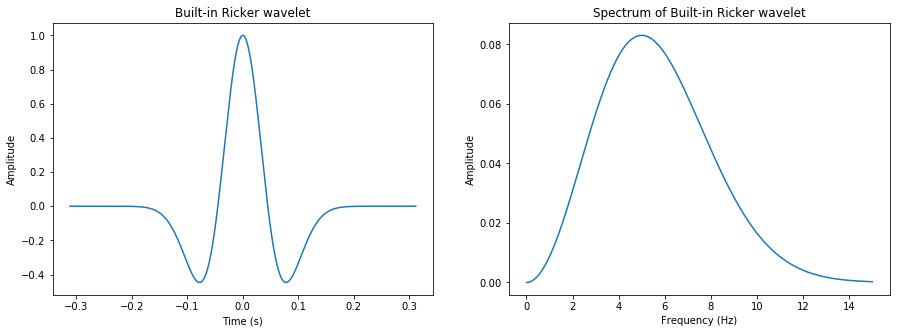

In [8]:
# Ricker wavelet
#.................................................
# refrence to the web tutorial of the 'Marmousi'
# https://salvus.io/examples/Jupytext/exploration/marmousi_2d/marmousi_2d/#frequency-content

wavelet = config.stf.Ricker(center_frequency=f_max / 2)
f, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(*wavelet.get_stf())
# ax[0].plot(*stf.get_stf())
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].set_title('Built-in Ricker wavelet')

ax[1].plot(*wavelet.get_power_spectrum())
# ax[1].plot(*stf.get_power_spectrum())
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Amplitude")
ax[1].set_title('Spectrum of Built-in Ricker wavelet')
#.................................................
print(wavelet)

### Sources file generate

In [9]:
#.................................................
stf = config.stf.Ricker(center_frequency=f_max / 2)
source = config.source.cartesian.VectorPoint2D(
   x=-30, y=0.0, fx=1.0, fy=1.0, source_time_function=stf
 )

In [10]:
#n_rec = 100
#.................................................
n_rec = 4
#.................................................
x_rec = np.ones(n_rec) * -building_width / 2
y_rec = np.linspace(0, n_stories * story_height, n_rec)
receivers = [                                    
    config.receiver.cartesian.Point2D(          
        x=x,
        y=y,
        station_code=f"{_i:03d}",
        fields=["velocity", "gradient-of-displacement","displacement","acceleration"],
#         fields=[ "gradient-of-displacement","velocity","acceleration"],
    )
    for _i, (x, y) in enumerate(zip(x_rec, y_rec))
]                                                      
#.................................................

# `item` must be one of: "displacement", "velocity", "acceleration", 
# "gradient-of-displacement", "strain", "phi", "phi_t", "phi_tt", "gradient-of-phi"

In [11]:
# Initialize with sources and receivers.
w_r = config.simulation.Waveform(mesh=mesh, sources=source, receivers=receivers)  
# "r" in "w_r"  means "Receiver" data 

# Set end time, start time is automatically determined.
w_r.physics.wave_equation.end_time_in_seconds = 1.0             # total time. unit: second

# Define and attach our absorbing boundaries.
ab = config.boundary.Absorbing(
    side_sets=["x0", "x1", "y0"], width_in_meters=bnd, taper_amplitude=f_max
)
w_r.physics.wave_equation.boundaries = [ab]

# Use simplified HDF5 source output.
w_r.output.point_data.format = "hdf5"

# Save the volumetric wavefield for visualization purposes.
# w.output.volume_data.format = "hdf5"
# w.output.volume_data.filename = "output.h5"
# w.output.volume_data.fields = ["displacement"]
# w.output.volume_data.sampling_interval_in_time_steps = 10

# Ensure that Salvus will accept our parameters.
w_r.validate()

# Plot the mesh with the sources and receivers.
w_r


In [12]:
#............To comment in the volumetric output for snapshot..........................
#.................................................
# We'll start with all of the 2-D parameterizations. 
# Again, to save space, we'll prepare our simulation.
# Waveform object with values which will be re-used.
w_A = sc.simulation.Waveform(mesh=mesh, sources=source)                
# "A" in "w_A"  means "All" wavefields 

# Set end time, start time is automatically determined.
w_A.physics.wave_equation.end_time_in_seconds = 1.0             # total time. unit: second

# Define and attach our absorbing boundaries.
ab = config.boundary.Absorbing(
    side_sets=["x0", "x1", "y0"], width_in_meters=bnd, taper_amplitude=f_max
)
w_A.physics.wave_equation.boundaries = [ab]

# w.domain.dimension = 2

w_A.output.volume_data.format = "hdf5"
w_A.output.volume_data.filename = "output.h5"
w_A.output.volume_data.fields = ["displacement"]
w_A.output.volume_data.sampling_interval_in_time_steps = 100

w_A

## Running the simulation

In [14]:

output_folder = Path("salvus data/Data reciever")
# output_folder = Path("/media/ygao/Elements/salvus data/Delta reciever")

api.run(
    ranks=4,
    get_all=True,
    input_file=w_r,
    overwrite=True,
    site_name="local_f64",
#     site_name="local",
    output_folder=output_folder,    
)

Job `job_1910031521274615_7a7321942b` running on `local_f64` with 4 rank(s).
Site information:
  * Salvus version: 0.10.1
  * Floating point size: 64



* Downloaded 34.3 MB of results to `salvus data/Delta reciever`.
* Total run time: 25.66 seconds.
* Pure simulation time: 24.22 seconds.


In [15]:
output_folder = Path("salvus data/Data snapshot")
# output_folder = Path("/media/ygao/Elements/salvus data/Delta snapshot")
# output_file = output_folder / "output.h5"

api.run(
    ranks=4,
    get_all=True,
    input_file=w_A,
    overwrite=True,
    site_name="local_f64",
#     site_name="local",
    output_folder=output_folder,
)

Job `job_1910031521230669_62d60ed195` running on `local_f64` with 4 rank(s).
Site information:
  * Salvus version: 0.10.1
  * Floating point size: 64



* Downloaded 377.0 MB of results to `salvus data/Delta snapshot`.
* Total run time: 35.67 seconds.
* Pure simulation time: 23.66 seconds.


## Analyzing the results

Text(0.5, 0, 'Time (s)')

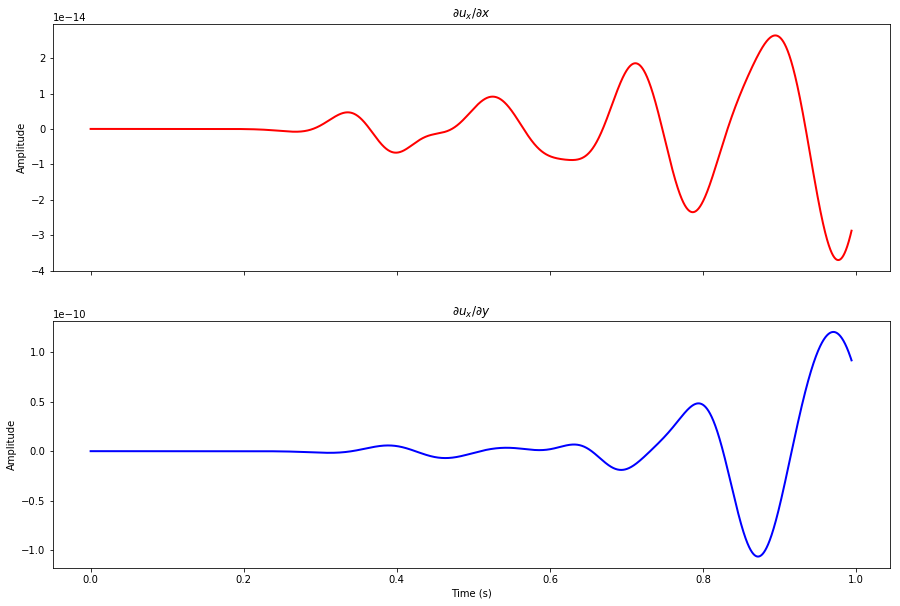

In [17]:
# Read in data.
rec_file = "salvus data/Data reciever/receivers.h5"

#field = "displacement"
field = "gradient-of-displacement"
uxx, dt, extent = st.get_shotgather(rec_file, field=field, cmp=0, axis=1)
uxy, _, _ = st.get_shotgather(rec_file, field=field, cmp=1, axis=1)
uyx, _, _ = st.get_shotgather(rec_file, field=field, cmp=2, axis=1)
uyy, _, _ = st.get_shotgather(rec_file, field=field, cmp=3, axis=1)


nt,nx=np.shape(uxx)
print(nt)
tt=np.linspace(0,(nt-1)*dt,nt)

f, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

start_n=0
end_n=85000
# end_n=25000


ax[0].plot(tt[start_n:end_n],uxx[start_n:end_n, nx - 1],color="red",linewidth=2)

ax[1].plot(tt[start_n:end_n],uxy[start_n:end_n, nx - 1],color="blue",linewidth=2)

# Label plots
ax[0].set_title(r"$\partial u_x / \partial x$")
ax[1].set_title(r"$\partial u_x / \partial y$")

# Label axes.
ax[0].set_ylabel("Amplitude")
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Time (s)")